# Locational Marginal Pricing (LMP) Forecasting using Keras

The following can be used to forecast PJM locational marginal prices in their real-time market using Feed Forward Neural Networks, Recurrent Neural Networks, and Long Short-Term Memory Networks. All of the data available (Outside of electric load forecasts) are available on PJM's website. The code could also be easily adapted for many neural network regression tasks. 

## Import 

In [1]:
import sys
import numpy as np
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import pyodbc 
import pandas as pd
from sklearn import preprocessing

C:\Users\jmorris\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# The Function

This is where the sufficiently advanced technology happens, and it is broken into several parts as seen below:

### Parameters

In the Parameters section, information inputted to the function (model type and test day) are broken up into binary variables which allows for simpler conditional organization later on. This is also where filepaths are specified if you are altering the data files and need to adjust the sources. The model information block in the output is specified here. 

### Load Zones

This section interprets the load_zone string passed to the function as a starting column in the main data file so that the proper losses, congestion, and whatnot can be found. It also specifies the *select* statement needed for the sequel query for load forecasts. Note: If you are trying to run this anywhere outside of TESLA, the load forecast retrieval will obviously not work. 

### SQL Queries

The code in this section queries TESLA Inc.'s databases to retrieve PJM's load forecasts for the specified times. It is currently retrieving load as of the beginning of 2016 because PJM does not have energy mix information before that year, and we want all of our features to have the same start date, end date, and granularity. 

### Load Data 

**('Load' as a verb and not a noun this time)**

The code in the Load Data section retrieves information necessary to run the model - the feature data and the LMP response. It reads from several datasets: the main LMP-losses-congestion datasets (**'PJM_loss_cong.csv'** and variants thereof), the energy mix dataset (**'PJM-Gen-Mix-2007-2018.csv'**), and the reserves dataset (**'PJM_Reserve_Rates_2007_2018.csv'**). The variants on the main dataset include other important information such as the calendar variables and delayed LMPs. The reading is done using **NumPy**'s *genfromtxt* function. The *unpack* parameter allows the information to be read as a collection of column variables as opposed to one whole matrix. 

After loading the data, the feature matrix $X$ and the response matrix $Y$ are broken up into training and testing sets based off of the test date chosen by the user. Additionally, all of the input data is *preprocessed* using SciKit-Learn's __[preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html)__ package. 

### Build Model

The Build Model section makes use of Python's deep learning library **Keras**. All sorts of information can be found in their __[online documentation](https://keras.io/)__ which I highly recommend exploring. I thought I had a grasp on what they offered when I started this project, but I proved myself wrong pretty quickly. I made simple mistakes like manually testing and evaluating the model as opposed to using their *evaluate* function. I also overlooked some of their other exciting offerings such as the Early Stopping mechanism for training. With more time, I would implement these. 

In this section, all of the build functions (passed as a parameter to KerasRegressor later) are specified. These include Dense (deep feed forward) neural nets, Recurrent neural nets, and Long Short-Term Memory networks. Depending on which parameters the user passes to the function, the KerasRegressor will take one or more of these build functions to create the models used for training and testing. Comments are given on the first build function to explain it a more step-by-step manner.

Whenever a layer is added to the network, a *kernel_initializer* is used to establish the weights and an activation function is chosen. I chose __['glorot_uniform_initializer'](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)__ for my *kernel_initializer* and __['relu'](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning)__ for my *activation*. 

When the model is compiled, a *loss* metric and an *optimizer* are chosen. I chose 'mean_squared_error' for my *loss* and __['adam'](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)__ for my *optimizer*. These are all open to be changed (and the layers need not all have the same initializers and activation functions), but I do believe this set will most likely give the best results. 

### Validate / Train / Test

In this section, the model is trained on the training set ($X_{train}$ and $Y_{train}$) allowing for the last tenth of the dataset to be used for validation. Once the model is trained, it is used to predict the response from $X_{test}$. This prediction is compared to $Y_{test}$ to determine the accuracy of the model.

### Plot

In this section, information from the Validate / Train / Test section is visualized. 

The first plot displays the training process. The blue line shows the testing error and the orange line shows the validation error. If the validation error ever starts to consistently increase, the model is becoming more and more overfit with more epochs of training. This is not desired and the model should be adjusted to use fewer epochs. 

The second plot displays the prediction on the user's chosen test day. The blue line will be the LMP actuals, and the orange line will be the predictions from the model. The third plot is the same as the second but displays about ten days before the chosen test day as well. 

In [20]:
def PJM_Net(load_zone = 'DOMINION', model_type='R', test_day='S5', epochs = 50, batch_size = 20, dropout_rate = 0.25):
    start = time.time()
    
    ####################################################     PARAMETERS     ################################################
    
    filepath = 'PJM_LMP_loss_cong.csv'
    filepath_1hr = 'PJM_LMP_loss_cong_1hrback.csv'
    filepath_2hr = 'PJM_LMP_loss_cong_2hrback.csv'
    filepath_1day = 'PJM_LMP_loss_cong_1dayback.csv'
    filepath_2day = 'PJM_LMP_loss_cong_2dayback.csv'
    filepath_hours_years = 'PJM_hours_years.csv'
    filepath_weekdays_season = 'PJM_hours_years.csv'
    filepath_mix = 'PJM-Gen-Mix-2007-2018.csv'
    filepath_reserves = 'PJM_Reserve_Rates_2007_2018.csv'
    
    t=1                                                                 # t for TESLA - allows for use of load forecasts
    
    d = 0                                                               # Model Type binaries to make conditionals easier
    r = 0
    l = 0
    a = 0
    if model_type == 'D':
        d=1
    elif model_type == 'R':
        r=1
    elif model_type == 'L':
        l=1
    elif model_type == 'A':
        a=1
    else:
        print("Model Choice Error - no type or invalid type chosen")
        sys.exit(0)
        
    s1, s2, s3, s4, s5, s6, s7 = 0, 0, 0, 0, 0, 0, 0                    # Test Day binaries to make conditionals easier
    w1, w2, w3, w4, w5, w6, w7 = 0, 0, 0, 0, 0, 0, 0
    if test_day == 'S1':
        s1 = 1
        test_day_text = "Sunday 6/24/18"
    elif test_day == 'S2':
        s2 = 1
        test_day_text = "Monday 6/25/18"
    elif test_day == 'S3':
        s3 = 1
        test_day_text = "Tuesday 6/26/18"
    elif test_day == 'S4':
        s4 = 1
        test_day_text = "Wednesday 6/27/18"
    elif test_day == 'S5':
        s5 = 1
        test_day_text = "Thursday 6/28/18"
    elif test_day == 'S6':
        s6 = 1
        test_day_text = "Friday 6/29/18"
    elif test_day == 'S7':
        s7 = 1
        test_day_text = "Saturday 6/30/18"
    elif test_day == 'W1':
        w1 = 1
        test_day_text = "Sunday 12/10/17"
    elif test_day == 'W2':
        w2 = 1
        test_day_text = "Monday 12/11/17"
    elif test_day == 'W3':
        w3 = 1
        test_day_text = "Tuesday 12/12/17"
    elif test_day == 'W4':
        w4 = 1
        test_day_text = "Wednesday 12/13/17"
    elif test_day == 'W5':
        w5 = 1
        test_day_text = "Thursday 12/14/17"
    elif test_day == 'W6':
        w6 = 1
        test_day_text = "Friday 12/15/17"
    elif test_day == 'W7':
        w7 = 1
        test_day_text = "Saturday 12/16/17"
    else:
        print("1: Test_Day_Error")
        sys.exit(0)

    if d:
        print("------- Dense Neural Net -------")
    elif r:
        print("----- Recurrent Neural Net -----")
    elif l:
        print("--------- LSTM Network ---------")
    elif a:
        print("-------- Ensemble Model --------")
    print("DATASET:      ", filepath)                                   # Output formatting
    print("LOAD ZONE:    ", load_zone)
    print("TEST ON:      ", test_day_text)
    print("EPOCHS:       ", epochs)
    print("BATCH SIZE:   ", batch_size)
    print("DROPOUT:      ", dropout_rate)
    print("--------------------------------")
    
    ###################################################     LOAD ZONES     #################################################
    
    # Interprets load zone input in order to read correct data from file correctly and query SQL properly
    
    if load_zone == 'AECO':
        startcol = 10 
        select = 'select date, time, load_fcst from pjm_ae_iso_load_fcst where date >= 20160101 and date <= 20180631'
    elif load_zone == 'AEP':
        startcol = 16
        select = 'select date, time, load_fcst from pjm_aepower_iso_load_fcst where date >= 20160101 and date <= 20180631'
    elif load_zone == 'APS':
        startcol = 22
        select = 'select date, time, load_fcst from pjm_aps_iso_load_fcst where date >= 20160101 and date <= 20180631'
    elif load_zone == 'ATSI':
        startcol = 28
        select = 'select date, time, load_fcst from pjm_atsi_iso_load_fcst where date >= 20160101 and date <= 20180631'
    elif load_zone == 'BGE':
        startcol = 34
        select = 'select date, time, load_fcst from pjm_bc_iso_load_fcst where date >= 20160101 and date <= 20180631'
    elif load_zone == 'COMED':
        startcol = 40
        select = 'select date, time, load_fcst from pjm_comed_iso_load_fcst where date >= 20160101 and date <= 20180631'
    elif load_zone == 'DAYTON':
        startcol = 47
        select = 'select date, time, load_fcst from pjm_dayton_load_fcst where date >= 20160101 and date <= 20180631'
    elif load_zone == 'DEOK':
        startcol = 53
        select = 'select date, time, load_fcst from pjm_deok_iso_load_fcst where date >= 20160101 and date <= 20180631'
    elif load_zone == 'DOMINION':
        startcol = 59
        select = 'select date, time, load_fcst from pjm_domin_iso_load_fcst where date >= 20160101 and date <= 20180631'
        # ...
    elif load_zone == 'MID-ATL':
        startcol = 96
        select = 'select date, time, load_fcst from pjm_midatlantic_iso_load_fcst where date >= 20160101 and date <= 20180631'
    elif load_zone == 'PJM-RTO':
        startcol = 120
        select = 'select date, time, load_fcst from pjm_rto_iso_load_fcst where date >= 20160101 and date <= 20180631'
    elif load_zone == 'HOURLY':
        startcol = 80
        select = 'select date, time, load_fcst from pjm_total_load_fcst where date >= 20160101 and date <= 20180631'
    else:
        print("The selected load zone does not match one on file. Try another load zone such as `DOMINION'.")
        return
    
    ####################################################     SQL QUERIES     ###############################################
    
    if t:
        cnxn1 = pyodbc.connect("Driver={SQL Server};"
                              "Server=usdbsvr9;"
                              "Database=pjm;"
                              "Trusted_Connection=yes;")


        df = pd.read_sql_query(select, cnxn1, index_col=['date', 'time'])
        load = df.values 
        load = np.reshape(load, (load.shape[0],))
    
    ####################################################     LOAD DATA     #################################################
    
    # Reading in data from excel sheets
    
    print('Loading data...')
    
    # Reading in LMP, losses, congestion in real time as well as historical LMP information
    lmp, loss, cong = np.genfromtxt(filepath, delimiter=',', skip_header=5137, skip_footer = 0, usecols=(startcol, startcol+1, startcol+2), unpack=1)
    hr1back = np.genfromtxt(filepath_1hr, delimiter=',', skip_header=5137, skip_footer = 0, usecols=(startcol), unpack=1)
    hr2back = np.genfromtxt(filepath_2hr, delimiter=',', skip_header=5137, skip_footer = 0, usecols=(startcol), unpack=1)
    day1back = np.genfromtxt(filepath_1day, delimiter=',', skip_header=5137, skip_footer = 0, usecols=(startcol), unpack=1)
    day2back = np.genfromtxt(filepath_2day, delimiter=',', skip_header=5137, skip_footer = 0, usecols=(startcol), unpack=1)
    
    # Seasonality and Weekends - consider adding Friday later
    summer, sat, sun = np.genfromtxt(filepath_weekdays_season, delimiter=',', skip_header=5137, skip_footer = 0, usecols=(1, 2, 3), unpack=1)
    weekend = sat + sun
    
    dates = np.arange('2016-01-01T00', '2018-07-01T00', dtype='datetime64[h]')

    #Hourly and Yearly Dummies
    zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree, y2015, y2016, y2017 = np.genfromtxt(filepath_hours_years, delimiter=',', skip_header=5137, skip_footer = 0, usecols=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,20, 21, 22, 23, 24, 25, 26, 27), unpack=1)
    
    # Energy Mix
    coal, gas, hist, hydro, mult, nucl, oil, othernr, otherr, solar, wind   = np.genfromtxt(filepath_mix, delimiter=',', skip_header=26129, skip_footer = 0, usecols=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12), unpack=1)
    
    # Reserves Data
    reserves = pd.read_csv(filepath_reserves, sep=',', names=['Dates','DAOpRes', 'EastDev', 'EastRel', 'RTODev', 'RTORel', 'WestDev', 'WestRel'], index_col=0, skiprows=1100, parse_dates=[0])

    upsampled = reserves.resample('H')
    intup_reserves = upsampled.interpolate(method='linear')
    reserves_ui = intup_reserves.drop(intup_reserves.index[len(intup_reserves)-1])

    res=reserves_ui.values
    daOpRes = res[:,0]
    eastDev = res[:,1]        # East and West reserves data yet to be used with success
    eastRel = res[:,2]
    rtoDev = res[:,3]
    rtoRel = res[:,4]
    westDev = res[:,5]
    westRel = res[:,6]
    
    
    #  Putting all the variables together into a feature matrix X. 
    #  Feel free to change which variables are used - this is by no means the best variable set.
    
    if t: 
        if load_zone == 'PJM-RTO':                                                  # PJM-RTO hates loss and congestion for some reason
            X = np.vstack((load, coal, gas, hydro, mult, nucl, oil, othernr, otherr, solar, wind, weekend, hr1back, hr2back, day1back, day2back, zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree, y2016, y2017, rtoDev, rtoRel, daOpRes)).T
        else:
            X = np.vstack((loss, cong, load, coal, gas, hydro, mult, nucl, oil, othernr, otherr, solar, wind, weekend, hr1back, hr2back, day1back, day2back, zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree, y2016, y2017, rtoDev, rtoRel, daOpRes)).T

    else:
        if load_zone == 'PJM-RTO':                                                  # PJM-RTO hates loss and congestion for some reason
            X = np.vstack((coal, gas, hydro, mult, nucl, oil, othernr, otherr, solar, wind, weekend, hr1back, hr2back, day1back, day2back, zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree, y2016, y2017, rtoDev, rtoRel, daOpRes)).T
        else:
            X = np.vstack((loss, cong, coal, gas, hydro, mult, nucl, oil, othernr, otherr, solar, wind, weekend, hr1back, hr2back, day1back, day2back, zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree, y2016, y2017, rtoDev, rtoRel, daOpRes)).T

            
    #  Response matrix Y
    Y = lmp.T
    
    #  Test dates - feel free to test on different dates and/or choose a new system for testing altogether
    
        #####     SUMMER     #####
       
    if s1:
        splitline = X.shape[0]-144      #for testing Sunday, June 24
        splitline2 = X.shape[0]-168
    elif s2:  
        splitline = X.shape[0]-120      #for testing Monday, June 25
        splitline2 = X.shape[0]-144
    elif s3:    
        splitline = X.shape[0]-96      #for testing Tuesday, June 26
        splitline2 = X.shape[0]-120
    elif s4:    
        splitline = X.shape[0]-72      #for testing Wednesday, June 27
        splitline2 = X.shape[0]-96 
    elif s5:    
        splitline = X.shape[0]-48      #for testing Thursday, June 28
        splitline2 = X.shape[0]-72
    elif s6:    
        splitline = X.shape[0]-24      #for testing Friday, June 29
        splitline2 = X.shape[0]-48
    elif s7:   
        splitline = X.shape[0]         #for testing Saturday, June 30
        splitline2 = X.shape[0]-24
        
        
             #####     WINTER     #####
    elif w1:         
        splitline = X.shape[0]-144-196*24      #for testing Sunday, December 10
        splitline2 = X.shape[0]-168-196*24 
    elif w2:    
        splitline = X.shape[0]-120-196*24      #for testing Monday, December 11
        splitline2 = X.shape[0]-144-196*24 
    elif w3:    
        splitline = X.shape[0]-96-196*24       #for testing Tuesday, December 12
        splitline2 = X.shape[0]-120-196*24 
    elif w4:    
        splitline = X.shape[0]-72-196*24       #for testing Wednesday, December 13
        splitline2 = X.shape[0]-96-196*24  
    elif w5:    
        splitline = X.shape[0]-48-196*24       #for testing Thursday, December 14
        splitline2 = X.shape[0]-72-196*24 
    elif w6:    
        splitline = X.shape[0]-24-196*24       #for testing Friday, December 15
        splitline2 = X.shape[0]-48-196*24 
    elif w7:    
        splitline = X.shape[0]-196*24          #for testing Saturday, December 16
        splitline2 = X.shape[0]-24-196*24 
    else:
        print("2: Test_Day_Error")
        sys.exit(0)
            
    X_train_pp = X[0:splitline2]                                            #   splits X and Y into train and test sets
    X_test_pp = X[splitline2:splitline]                                     #    'pp' for Pre-Preprocessing
    Y_train = Y[0:splitline2]
    Y_test = Y[splitline2:splitline]
    
    scaler = preprocessing.StandardScaler().fit(X_train_pp)                 # Preprocessing the data (substracting mean / dividing by standard deviation and whatnot)
    X_train = scaler.transform(X_train_pp)
    X_test = scaler.transform(X_test_pp)
    
    
    ###################################################     BUILD MODEL     ##############################################
    
    if r:   #  Recurrent Neural Net
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X.shape[1]))          #   Reshaping features to fit the network
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X.shape[1]))
        def baseline_model():
            print('Building Recurrent Neural Network...')
            model = Sequential()
            model.add(Dropout(dropout_rate, input_shape=(1,X.shape[1])))                  #   Adds dropout to input              
            hiddenLayerSize = int(X.shape[1] + 2 - 0.165*X.shape[1])                      #   Specifies size of first hidden layer
            #print("VARIABLES:     ", X.shape[1])
            #print("HIDDEN LAYER1: ", hiddenLayerSize)     
            model.add(SimpleRNN(hiddenLayerSize, input_shape=(1,X.shape[1]),               #   Builds first hidden layer 
                kernel_initializer='glorot_uniform', activation='relu'))
            model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize)))              #   Adds dropout to first hidden layer
            if hiddenLayerSize >= 25:                                                      #   If the first hidden layer is big enough,
                hiddenLayerSize2 = int(hiddenLayerSize/3)                                  #     there can be a second hidden layer
                #print("HIDDEN LAYER2: ", hiddenLayerSize2)
                model.add(Dense(hiddenLayerSize2, input_shape=(1,hiddenLayerSize),               
                                kernel_initializer='glorot_uniform', activation='relu'))
                model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize)))
                model.add(Dense(1, input_shape=(1,hiddenLayerSize2),                            #   Builds single-node output layer
                                kernel_initializer='glorot_uniform'))  
            else:
                model.add(Dense(1, input_shape=(1,hiddenLayerSize),                            #   Builds single-node output layer
                                kernel_initializer='glorot_uniform'))        
            model.compile(loss='mean_squared_error', optimizer='adam')
            return model
        
        estimator = KerasRegressor(build_fn=baseline_model,                             #   Parameters given by user
            epochs=epochs, batch_size=batch_size, verbose=True)
    
    elif d:   #  Dense Neural Net
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X.shape[1]))          #   Reshaping features to fit the network
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X.shape[1]))
        Y_train2 = np.reshape(Y_train, (Y_train.shape[0], 1, 1))
        def baseline_model():
            print('Building Dense Neural Network...')
            model = Sequential()
            model.add(Dropout(dropout_rate, input_shape=(1,X.shape[1])))                       
            hiddenLayerSize = int(X.shape[1] + 2 - 0.165*X.shape[1])
            #print("VARIABLES:     ", X.shape[1])
            #print("HIDDEN LAYER1: ", hiddenLayerSize)     
            model.add(Dense(hiddenLayerSize, input_shape=(1,X.shape[1]),               
                kernel_initializer='glorot_uniform', activation='relu'))
            model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize)))
            if hiddenLayerSize >= 25:
                hiddenLayerSize2 = int(hiddenLayerSize/3)
                #print("HIDDEN LAYER2: ", hiddenLayerSize2)
                model.add(Dense(hiddenLayerSize2, input_shape=(1,hiddenLayerSize),               
                                kernel_initializer='glorot_uniform', activation='relu'))
                model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize2)))
                model.add(Dense(1, input_shape=(1,hiddenLayerSize2),                           
                                kernel_initializer='glorot_uniform'))  
            else:
                model.add(Dense(1, input_shape=(1,hiddenLayerSize),                            
                                kernel_initializer='glorot_uniform'))        
            model.compile(loss='mean_squared_error', optimizer='adam')
            return model
        
        estimator = KerasRegressor(build_fn=baseline_model,                             
            epochs=epochs, batch_size=batch_size, verbose=True)
        
    elif l:   #  LSTM
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X.shape[1]))          
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X.shape[1]))
        def baseline_model():
            print('Building Long Short-Term Memory Network...')
            model = Sequential()
            model.add(Dropout(dropout_rate, input_shape=(1,X.shape[1])))                      
            hiddenLayerSize = int(X.shape[1] + 2 - 0.165*X.shape[1])
            #print("VARIABLES:     ", X.shape[1])
            #print("HIDDEN LAYER1: ", hiddenLayerSize)    
            model.add(LSTM(hiddenLayerSize, input_shape=(1,X.shape[1]),               
                kernel_initializer='glorot_uniform', activation='relu'))
            model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize)))
            if hiddenLayerSize >= 25:
                hiddenLayerSize2 = int(hiddenLayerSize/3)
                #print("HIDDEN LAYER2: ", hiddenLayerSize2)
                model.add(Dense(hiddenLayerSize2, input_shape=(1,hiddenLayerSize),               
                                kernel_initializer='glorot_uniform', activation='relu'))
                model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize2)))
                model.add(Dense(1, input_shape=(1,hiddenLayerSize2),                            
                                kernel_initializer='glorot_uniform'))  
            else:
                model.add(Dense(1, input_shape=(1,hiddenLayerSize),                            
                                kernel_initializer='glorot_uniform'))        
            model.compile(loss='mean_squared_error', optimizer='adam')
            return model
        
        estimator = KerasRegressor(build_fn=baseline_model,                             
            epochs=epochs, batch_size=batch_size, verbose=False)
        
    elif a:   #  Ensemble (All/Average) Model
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X.shape[1]))          
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X.shape[1]))
        def baseline_modelRNN():
            print('Building Recurrent Neural Network...')
            model = Sequential()
            model.add(Dropout(dropout_rate, input_shape=(1,X.shape[1])))                       
            hiddenLayerSize = int(X.shape[1] + 2 - 0.165*X.shape[1])
            #print("VARIABLES:     ", X.shape[1])
            #print("HIDDEN LAYER1: ", hiddenLayerSize)     
            model.add(SimpleRNN(hiddenLayerSize, input_shape=(1,X.shape[1]),               
                kernel_initializer='glorot_uniform', activation='relu'))
            model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize)))
            if hiddenLayerSize >= 25:
                hiddenLayerSize2 = int(hiddenLayerSize/3)
                #print("HIDDEN LAYER2: ", hiddenLayerSize2)
                model.add(Dense(hiddenLayerSize2, input_shape=(1,hiddenLayerSize),               
                                kernel_initializer='glorot_uniform', activation='relu'))
                model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize2)))
                model.add(Dense(1, input_shape=(1,hiddenLayerSize2),                            
                                kernel_initializer='glorot_uniform'))  
            else:
                model.add(Dense(1, input_shape=(1,hiddenLayerSize),                            
                                kernel_initializer='glorot_uniform'))        
            model.compile(loss='mean_squared_error', optimizer='adam')
            return model
        
        estimatorRNN = KerasRegressor(build_fn=baseline_modelRNN,                             
            epochs=epochs, batch_size=batch_size, verbose=True)
    

        Y_train2 = np.reshape(Y_train, (Y_train.shape[0], 1, 1))
        def baseline_modelDNN():
            print('Building Dense Neural Network...')
            model = Sequential()
            model.add(Dropout(dropout_rate, input_shape=(1,X.shape[1])))                       
            hiddenLayerSize = int(X.shape[1] + 2 - 0.165*X.shape[1])
            #print("VARIABLES:     ", X.shape[1])
            #print("HIDDEN LAYER1: ", hiddenLayerSize)
            #hiddenLayerSize = X.shape[1]-1   
            #model.add(Reshape((1, X.shape[1]), input_shape=(1,X.shape[1])))      
            model.add(Dense(hiddenLayerSize, input_shape=(1,X.shape[1]),               
                kernel_initializer='glorot_uniform', activation='relu'))
            model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize)))
            if hiddenLayerSize >= 25:
                hiddenLayerSize2 = int(hiddenLayerSize/3)
                #print("HIDDEN LAYER2: ", hiddenLayerSize2)
                #model.add(Reshape((1, hiddenLayerSize), input_shape=(1, hiddenLayerSize)))
                model.add(Dense(hiddenLayerSize2, input_shape=(1,hiddenLayerSize),               
                                kernel_initializer='glorot_uniform', activation='relu'))
                model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize2)))
                model.add(Dense(1, input_shape=(1,hiddenLayerSize2),                            
                                kernel_initializer='glorot_uniform'))  
            else:
                model.add(Dense(1, input_shape=(1,hiddenLayerSize),                           
                                kernel_initializer='glorot_uniform'))        
            model.compile(loss='mean_squared_error', optimizer='adam')
            return model
        
        estimatorDNN = KerasRegressor(build_fn=baseline_modelDNN,                             
            epochs=epochs, batch_size=batch_size, verbose=True)
        
        
        def baseline_modelLSTM():
            print('Building Long Short-Term Memory Network...')
            model = Sequential()
            model.add(Dropout(dropout_rate, input_shape=(1,X.shape[1])))                       
            hiddenLayerSize = int(X.shape[1] + 2 - 0.165*X.shape[1])
            #print("VARIABLES:     ", X.shape[1])
            #print("HIDDEN LAYER1: ", hiddenLayerSize)      
            model.add(LSTM(hiddenLayerSize, input_shape=(1,X.shape[1]),               
                kernel_initializer='glorot_uniform', activation='relu'))
            model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize)))
            if hiddenLayerSize >= 25:
                hiddenLayerSize2 = int(hiddenLayerSize/3)
                #print("HIDDEN LAYER2: ", hiddenLayerSize2)
                model.add(Dense(hiddenLayerSize2, input_shape=(1,hiddenLayerSize),              
                                kernel_initializer='glorot_uniform', activation='relu'))
                model.add(Dropout(dropout_rate, input_shape=(1,hiddenLayerSize2)))
                model.add(Dense(1, input_shape=(1,hiddenLayerSize2),                            
                                kernel_initializer='glorot_uniform'))  
            else:
                model.add(Dense(1, input_shape=(1,hiddenLayerSize),                            
                                kernel_initializer='glorot_uniform'))        
            model.compile(loss='mean_squared_error', optimizer='adam')
            return model
        
        estimatorLSTM = KerasRegressor(build_fn=baseline_modelLSTM,                             
            epochs=epochs, batch_size=batch_size, verbose=True)
    
    ###############################################     VALIDATE / TRAIN / TEST     #############################################
    
    #print('Training...')
    if r or l or d:
        if r or l:
            history = estimator.fit(X_train, Y_train, validation_split=0.1)
        elif d:
            history = estimator.fit(X_train, Y_train2, validation_split=0.1)
        else:
            print("Model Choice Error - nothing to fit")
            sys.exit(0)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.ylim((0, 1000))
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train Set', 'Validating Set'], loc='upper left')
        print('Testing...')                                                             #   Fitting model to training data
        prediction = estimator.predict(X_test)                                          #   Predicting test data response based on training
        train_error =  np.abs(Y_test - prediction)                                      #   Evaluating performance on test data
        mean_error = np.mean(train_error)
        min_error = np.min(train_error)
        max_error = np.max(train_error)
        std_error = np.std(train_error)
        print("---------- Test Results ----------")
        print("MEAN ERROR:     ", str(round(mean_error,4)))
        print("STANDARD ERROR: ", str(round(std_error,4)))
        print("MIN ERROR:      ", str(round(min_error,4)))
        print("MAX ERROR:      ", str(round(max_error,4)))
        print("----------------------------------")
        test_mape = 100*np.mean(np.abs(np.divide(train_error,Y_test, where=Y_test!=0)))
        print("Test MAPE:      ", str(round(test_mape,4)))
        test_rmse = np.sqrt(np.mean(np.square(Y_test-prediction)))
        print("Test RMSE:      ", str(round(test_rmse,4)))
        print("----------------------------------")
        
        ###############################################     PLOT     ##########################################################
        
        plt.subplot(1, 2, 2)
        plt.plot(dates[splitline2:splitline], Y_test, label = "Test Data")
        plt.plot(dates[splitline2:splitline], prediction, label = "Predictions")
        plt.title("Predictions vs. Test Data")
        plt.legend()
        plt.show()
        
        daysback = 10
        hoursback = 24*daysback
        X_compare = X[splitline2-hoursback:splitline2]
        X_compare = scaler.transform(X_compare)
        X_compare = np.reshape(X_compare, (X_compare.shape[0], 1, X_compare.shape[1]))
        pastWeek = estimator.predict(X_compare)
        pred_plot = np.concatenate((pastWeek, prediction))
        act_plot = np.concatenate((Y[splitline2-hoursback:splitline2], Y_test))
        plt.plot(act_plot, label = "Actuals")
        plt.plot(pred_plot, label = "Predictions")
        plt.legend()
        plt.title('History')
        plt.show()
        
      
        #trainpred = estimator.predict(X_train)
        #all_pred = np.concatenate((trainpred, prediction))
        
        #plt.plot(dates, lmp[:21840])
        #plt.plot(dates, all_pred)
        
        #print("-----------------TOTAL RESULTS-----------------")
        #train_error_all = np.abs(lmp[:21840]-all_pred)
        #mape_all = 100*np.mean(np.abs(np.divide(train_error_all,lmp[:21840], where=lmp[:21840]!=0)))
        #print("MAPE:      ", str(round(mape_all,4)))
        #rmse_all = np.sqrt(np.mean(np.square(lmp[:21840]-all_pred)))
        #print("RMSE:      ", str(round(rmse_all,4)))
        #print("-----------------------------------------------")
        #plt.show()
  
    elif a:
        historyDNN = estimatorDNN.fit(X_train, Y_train2, validation_split=0.1)
        historyRNN = estimatorRNN.fit(X_train, Y_train, validation_split=0.1)
        historyLSTM = estimatorLSTM.fit(X_train, Y_train, validation_split=0.1)
        
        ######  DNN #######
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(historyDNN.history['loss'])
        plt.plot(historyDNN.history['val_loss'])
        plt.ylim((0, 1000))
        plt.title('DNN: Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train Set', 'Validating Set'], loc='upper left')
        #plt.show()
        print('DNN Testing...')                                                             #   Fitting model to training data
        predictionDNN = estimatorDNN.predict(X_test)                                          #   Predicting test data response based on training
        train_errorDNN =  np.abs(Y_test - predictionDNN)                                      #   Evaluating performance on test data
        mean_errorDNN = np.mean(train_errorDNN)
        min_errorDNN = np.min(train_errorDNN)
        max_errorDNN = np.max(train_errorDNN)
        std_errorDNN = np.std(train_errorDNN)
        print("---------- DNN Test Results ----------")
        print("MEAN ERROR:     ", str(round(mean_errorDNN,4)))
        print("STANDARD ERROR: ", str(round(std_errorDNN,4)))
        print("MIN ERROR:      ", str(round(min_errorDNN,4)))
        print("MAX ERROR:      ", str(round(max_errorDNN,4)))
        print("----------------------------------")
        test_mapeDNN = 100*np.mean(np.abs(np.divide(train_errorDNN,Y_test, where=Y_test!=0)))
        print("Test MAPE:      ", str(round(test_mapeDNN,4)))
        test_rmseDNN = np.sqrt(np.mean(np.square(Y_test-predictionDNN)))
        print("Test RMSE:      ", str(round(test_rmseDNN,4)))
        print("----------------------------------")
        
        plt.subplot(1, 2, 2)
        plt.plot(dates[splitline2:splitline], Y_test, label = "Test Data")
        plt.plot(dates[splitline2:splitline], predictionDNN, label = "Predictions")
        plt.title("DNN: Predictions vs. Test Data")
        plt.legend()
        plt.show()
        
        
        ######  RNN #######
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(historyRNN.history['loss'])
        plt.plot(historyRNN.history['val_loss'])
        plt.ylim((0, 1000))
        plt.title('RNN: Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train Set', 'Validating Set'], loc='upper left')
        #plt.show()
        print('RNN Testing...')                                                             #   Fitting model to training data
        predictionRNN = estimatorRNN.predict(X_test)                                          #   Predicting test data response based on training
        train_errorRNN =  np.abs(Y_test - predictionRNN)                                      #   Evaluating performance on test data
        mean_errorRNN = np.mean(train_errorRNN)
        min_errorRNN = np.min(train_errorRNN)
        max_errorRNN = np.max(train_errorRNN)
        std_errorRNN = np.std(train_errorRNN)
        print("---------- RNN Test Results ----------")
        print("MEAN ERROR:     ", str(round(mean_errorRNN,4)))
        print("STANDARD ERROR: ", str(round(std_errorRNN,4)))
        print("MIN ERROR:      ", str(round(min_errorRNN,4)))
        print("MAX ERROR:      ", str(round(max_errorRNN,4)))
        print("----------------------------------")
        test_mapeRNN = 100*np.mean(np.abs(np.divide(train_errorRNN,Y_test, where=Y_test!=0)))
        print("Test MAPE:      ", str(round(test_mapeRNN,4)))
        test_rmseRNN = np.sqrt(np.mean(np.square(Y_test-predictionRNN)))
        print("Test RMSE:      ", str(round(test_rmseRNN,4)))
        print("----------------------------------")
        
        plt.subplot(1, 2, 2)
        plt.plot(dates[splitline2:splitline], Y_test, label = "Test Data")
        plt.plot(dates[splitline2:splitline], predictionRNN, label = "Predictions")
        plt.title("RNN: Predictions vs. Test Data")
        plt.legend()
        plt.show()
        
        
        ######  LSTM  #######
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(historyLSTM.history['loss'])
        plt.plot(historyLSTM.history['val_loss'])
        plt.ylim((0, 1000))
        plt.title('LSTM: Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train Set', 'Validating Set'], loc='upper left')
        print('LSTM Testing...')                                                             #   Fitting model to training data
        predictionLSTM = estimatorLSTM.predict(X_test)                                          #   Predicting test data response based on training
        train_errorLSTM =  np.abs(Y_test - predictionLSTM)                                      #   Evaluating performance on test data
        mean_errorLSTM = np.mean(train_errorLSTM)
        min_errorLSTM = np.min(train_errorLSTM)
        max_errorLSTM = np.max(train_errorLSTM)
        std_errorLSTM = np.std(train_errorLSTM)
        print("-------- LSTM Test Results --------")
        print("MEAN ERROR:     ", str(round(mean_errorLSTM,4)))
        print("STANDARD ERROR: ", str(round(std_errorLSTM,4)))
        print("MIN ERROR:      ", str(round(min_errorLSTM,4)))
        print("MAX ERROR:      ", str(round(max_errorLSTM,4)))
        print("----------------------------------")
        test_mapeLSTM = 100*np.mean(np.abs(np.divide(train_errorLSTM,Y_test, where=Y_test!=0)))
        print("Test MAPE:      ", str(round(test_mapeLSTM,4)))
        test_rmseLSTM = np.sqrt(np.mean(np.square(Y_test-predictionLSTM)))
        print("Test RMSE:      ", str(round(test_rmseLSTM,4)))
        print("----------------------------------")
        
        plt.subplot(1, 2, 2)
        plt.plot(dates[splitline2:splitline], Y_test, label = "Test Data")
        plt.plot(dates[splitline2:splitline], predictionLSTM, label = "Predictions")
        plt.title("LSTM: Predictions vs. Test Data")
        plt.legend()
        plt.show()
        
        
        #######  AVERAGING  ########
        averages = np.mean([predictionDNN, predictionRNN, predictionLSTM], axis=0)
        plt.plot(dates[splitline2:splitline], Y_test, label = "Test Data")
        plt.plot(dates[splitline2:splitline], averages, label = "Ensemble Prediction")
        plt.title('Averaged Prediction')
        plt.legend()
        train_errorAVE =  np.abs(Y_test - averages)                                      #   Evaluating performance on test data
        mean_errorAVE = np.mean(train_errorAVE)
        min_errorAVE = np.min(train_errorAVE)
        max_errorAVE = np.max(train_errorAVE)
        std_errorAVE = np.std(train_errorAVE)
        print("-------------------------------------------")
        print("---------- Ensemble Test Results ----------")
        print("-------------------------------------------")
        print("MEAN ERROR:     ", str(round(mean_errorAVE,4)))
        print("STANDARD ERROR: ", str(round(std_errorAVE,4)))
        print("MIN ERROR:      ", str(round(min_errorAVE,4)))
        print("MAX ERROR:      ", str(round(max_errorAVE,4)))
        print("-------------------------------------------")
        test_mape = 100*np.mean(np.abs(np.divide(train_errorAVE,Y_test, where=Y_test!=0)))
        print("Test MAPE:      ", str(round(test_mape,4)))
        test_rmse = np.sqrt(np.mean(np.square(Y_test-averages)))
        print("Test RMSE:      ", str(round(test_rmse,4)))
        print("-------------------------------------------")
        plt.show()
        
    
    end = time.time()
    print("Time Elapsed: ", end-start, " seconds")
    return test_mape, test_rmse


## Try It Out!

The function above, **PJM_Net()**, takes the following parameters in this order:

 - Load Zone -- default 'DOMINION' -- other options include:
      - 'PJM-RTO'
      - 'MID-ATL'
      - 'HOURLY'
      - 'AECO'
      - 'AEP'
      - 'APS'
      - 'ATSI'
      - 'BGE'
      - 'COMED'
      - 'DAYTON'
      - 'DEOK'
       - If you want to add other PJM load zones, you would have to add a new conditional statement for each containing the select statement for the load query and a start column for data retrieval. 
      
 - Model Type -- default 'R' for Recurrent Neural Network -- other options include:
      - 'D' -- Dense Neural Network
      - 'L' -- Long Short-Term Memory Network
      - 'A' -- Ensemble Model (for Average or All) - averages results of other three options
      
 - Test Date -- default 'S5' for Thursday, June 28th, 2018 -- other options include:
      - 'S1'-'S7' -- June 24th - June 30th, 2018
      - 'W1'-'W7' -- December 10th - December 16th, 2017
      
 - Epoch -- default 50 -- any positive integer
 
 - Batch Size -- default 20 -- any positive integer
 
 - Dropout Rate -- default 0.25 -- any float between 0 and 0.5
 
 Thus, simply using 'PJM_Net()' below will run a Recurrent neural net on PJM's Dominion load zone testing on June 28th, and it would iterate through the dataset 50 times with a batch size of 20 observations and dropping out 25% of non-output layer nodes. 
 
 But using 'PJM_Net('DAYTON', 'L', 'W1', 15)' would run an LSTM on the Dayton load zone, test on December 10th, and iterate through the dataset only 15 times. It would still use a batch size of 20, and it would still have a dropout rate of 25%. 
 
 Try it below!



------- Dense Neural Net -------
DATASET:       PJM_LMP_loss_cong.csv
LOAD ZONE:     DAYTON
TEST ON:       Monday 12/11/17
EPOCHS:        15
BATCH SIZE:    20
DROPOUT:       0.25
--------------------------------
Loading data...
Building Dense Neural Network...
Train on 15336 samples, validate on 1704 samples
Epoch 1/15
15336/15336 [==============================] - 2s 134us/step - loss: 485.0413 - val_loss: 93.3437
Epoch 2/15
15336/15336 [==============================] - 1s 55us/step - loss: 225.2159 - val_loss: 78.2143
Epoch 3/15
15336/15336 [==============================] - 1s 55us/step - loss: 237.0672 - val_loss: 73.3107
Epoch 4/15
15336/15336 [==============================] - 1s 55us/step - loss: 203.1198 - val_loss: 74.5297
Epoch 5/15
15336/15336 [==============================] - 1s 55us/step - loss: 213.1226 - val_loss: 92.2612
Epoch 6/15
15336/15336 [==============================] - 1s 55us/step - loss: 195.9247 - val_loss: 80.7727
Epoch 7/15
15336/15336 [=================

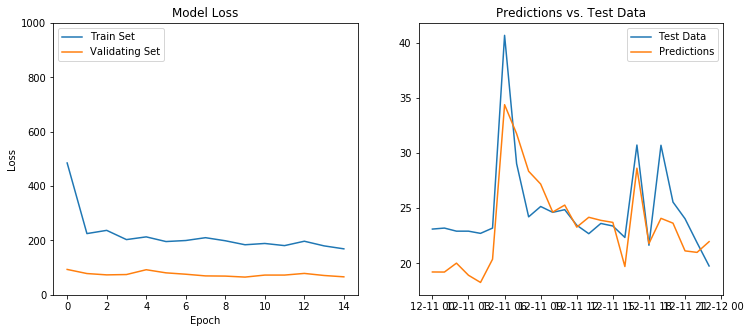

240/240 [==============================] - 0s 0us/step


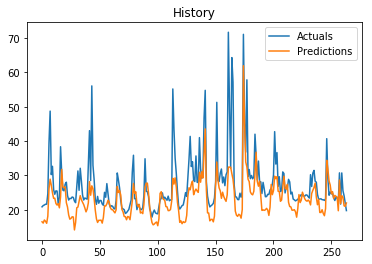

Time Elapsed:  18.733352422714233  seconds


(9.72835895471759, 3.079740740868776)

In [22]:
PJM_Net('DAYTON', 'D', 'W2', 15)

If it worked, you should have seen a block of text displaying your model parameters, a series of progress bars for each of the 15 epochs, and three plots! 

I chose not to seed the initializers and to take other steps to enhance reproducibility, but if your results are anything like mine, it should have taken about 20 seconds to achieve a MAPE of 9.8 and an RMSE of 3.2 even though the test plot still looks pretty bad. It's okay if your results are different from mine - it's pretty variable.

Use the block below to try whatever parameters you would like. I recommend trying an Ensemble Model to see each model type run in turn and how it differs from the other model types in its output.

-------- Ensemble Model --------
DATASET:       PJM_2015_2018.csv
LOAD ZONE:     AEP
TEST ON:       Tuesday 6/26/18
EPOCHS:        15
BATCH SIZE:    20
DROPOUT:       0.25
--------------------------------
Loading data...
Building Dense Neural Network...
Train on 19591 samples, validate on 2177 samples
Epoch 1/15
19591/19591 [==============================] - 2s 86us/step - loss: 518.8108 - val_loss: 360.2293
Epoch 2/15
19591/19591 [==============================] - 1s 55us/step - loss: 265.2754 - val_loss: 311.2746
Epoch 3/15
19591/19591 [==============================] - 1s 52us/step - loss: 252.6044 - val_loss: 303.4181
Epoch 4/15
19591/19591 [==============================] - 1s 52us/step - loss: 238.4170 - val_loss: 261.6025
Epoch 5/15
19591/19591 [==============================] - 1s 49us/step - loss: 242.2967 - val_loss: 255.2156
Epoch 6/15
19591/19591 [==============================] - 1s 49us/step - loss: 238.7262 - val_loss: 248.2607
Epoch 7/15
19591/19591 [===================

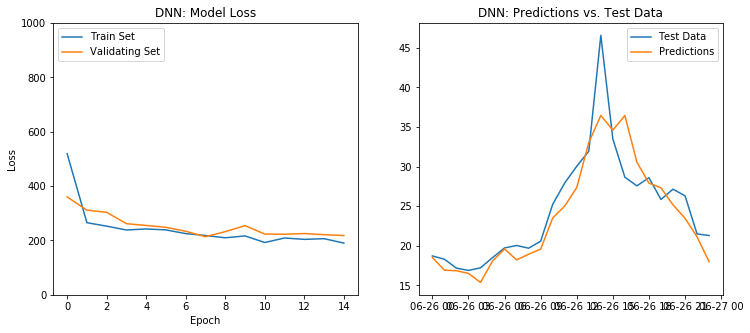

RNN Testing...
24/24 [==============================] - 0s 11ms/step
---------- RNN Test Results ----------
MEAN ERROR:      2.0326
STANDARD ERROR:  2.5315
MIN ERROR:       0.0444
MAX ERROR:       11.0504
----------------------------------
Test MAPE:       7.282
Test RMSE:       3.2466
----------------------------------


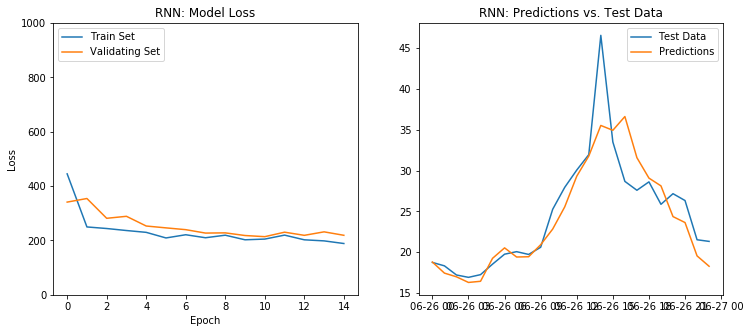

LSTM Testing...
24/24 [==============================] - 0s 13ms/step
-------- LSTM Test Results --------
MEAN ERROR:      1.86
STANDARD ERROR:  3.0353
MIN ERROR:       0.0924
MAX ERROR:       14.132
----------------------------------
Test MAPE:       6.1063
Test RMSE:       3.5598
----------------------------------


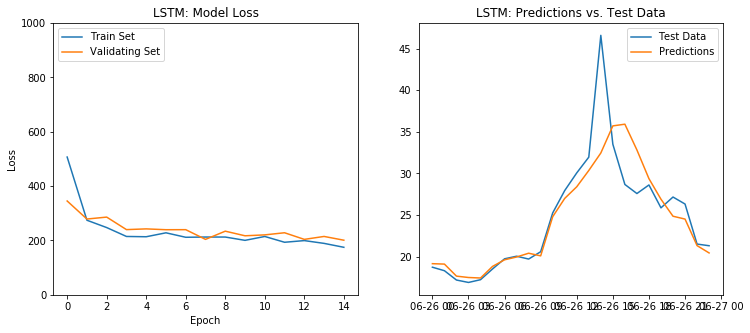

-------------------------------------------
---------- Ensemble Test Results ----------
-------------------------------------------
MEAN ERROR:      1.8237
STANDARD ERROR:  2.6506
MIN ERROR:       0.0276
MAX ERROR:       11.7664
-------------------------------------------
Test MAPE:       6.2083
Test RMSE:       3.2174
-------------------------------------------


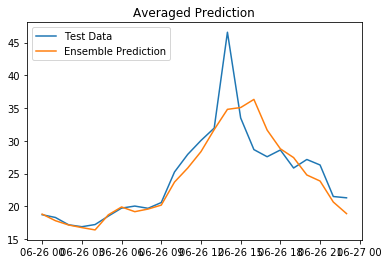

Time Elapsed:  79.62395095825195  seconds


(6.208333916395242, 3.217399167562015)

In [8]:
PJM_Net('AEP', 'A', 'S3', 15)

# Conclusions

With a fairly simple and suboptimal neural network model, it is feasible to forecast PJM's Locational Marginal Prices of energy on the wholesale market with single digit MAPEs and RMSEs. It is necessary to acknowledge that this is a bare minimum functioning model. Therefore, I want to enumerate what steps I would have taken to optimize and otherwise improve the model if I had more time to work on this project. 

### Optimization

 - **Network Structure** - When I was first running through trials with my first (Recurrent) model, I messed around with the hidden layer size to gauge what configuration might be close to ideal. I settled in on a system where the hidden layer size would grow with respect to the input size such that for small inputs, the hidden layer would be larger than the input layer, but for large inputs, the hidden layer would be smaller than the input layer. Additionally when the hidden layer reached a sufficient size, I added a second hidden layer which grew with respect to the first. If you did any kind of side-by-side comparison between models, you should have seen that the Recurrent model was the worst of the four by a fair margin, but I allowed this already suspect system to not only continue to be used, but also to be used for the other three models. It would be beneficial to systematically try different hidden layer sizes and numbers of hidden layers for each of the models to find a more optimal plan that may or may not be different for each model type. It is likely that this network structure also impacts other parameters such as epochs, batch size, and the dropout rate. 
 
 - **Grid Search** - I did use a very small grid search process (*SciKit-Learn*'s __[GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)__) to find an epoch-batch_size pair that worked best (50, 20) that I set as the default. However, I did this only in the early stages on my Recurrent model. It is likely that this varies very much not only between model types, but also with different network structures and certainly with different variable selections. Ideally, there would be a grid search system which, including dropout rate as well, would be able to select optimal parameters for all sorts of model configurations, and it would store this information for later use. I will discuss more of this in the next section.
 
 - **Variable Selection** - I did very little of this throughout the project. Most notably whenever I ran the 'PJM-RTO' load zone, the forecasts were always garbage. I tested various combinations and quickly learned that including either loss or congestion (two of the most significant features) would always end badly. Thus whenever I run PJM-RTO, I remove those two variables, and it looks just fine! Additionally, I ran a simple model with just 7 variables, and it performed significantly better than when I ran it with my normal selection of 40+ variables. This is all to say that different load zones react to different features differently, and some are much more helpful than others. With the currently small number of variables at our disposal, it shouldn't be too hard to determine more effective variable groupings by experimentation, but this would be slow and would be repeated slowly with the addition of any new models. It would be better to create a method of determining the relative importance of each feature within the model with a kind of significance rating. Then, the most significant features can be added in turn until adding variables no longer adds to the model's predicitive capability. 
 
 - **Callbacks** - **Keras** offers a wide variety of helpful tools under the umbrella of  __[*Callbacks*.](https://keras.io/callbacks/)__. I am most interested in *EarlyStopping* which allows a model to train and train and train as long as its validation error keeps improving, and it would stop whenever the validation error started to rise. This would allow us to train a model as long as possible without overfitting it to the training set. Another thing that is very important to note is incredible number of useful machine learning tools all over that can help - a quick search can do wonders. 
 
 - **Regularization** - To regularize my model, I used **Keras**'s *Dropout* layer. If you don't know about dropout, I would advise __[reading about it](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf)__ because it's pretty nifty. However, more traditional regularization methods, such as L1 and L2 regularization, are also at our disposal and may be very useful in preventing overfitting and keeping the model's predictive capacity generalizable. 
 
As you can see, there is plenty here to do just to tune parameters optimally all within the model. There is also much to add outside of the current model that could be helpful. 
 
 ### Additions

 - **Regression** - One of the coolest things about machine learning its modularity. It would not take many lines of code to add in other models like Ridge or LASSO regression. Other models of a completely different nature might add needed other perspectives in forecasting. Additionally, the Ensemble model could be adapted to include these other predictions as well. 
 
 - **Weighted Ensemble** - If you did a side-by-side comparison of model types, you might have a deeper understanding of the behavior of each. Dense and Recurrent feel a bit more timid and rarely overforecast the LMPs. LSTM has a tendency to look a bit more wild and often overshoots even the peaks, but it appears to find much better results than either Dense or Recurrent on average. It's this difference in behavior that makes the Ensemble model find such good results because they balance out close to the actuals. However, LSTM often beats Ensemble in RMSE and comes close in MAPE where the poorly forecasting Recurrent might be holding the Ensemble model back. Instead of a mean of the results at each hour, the Ensemble could be a weighted sum of the predictions from each. It could give LSTM a bigger weight than Recurrent, and I imagine the results would be much better. Other regression models added later could also be included. I expect that the set of weights to find the best prediction would vary from model to model, but this information could be stored for later use. 
 
 - **Different/More/Better Data** - In an exploratory phase before I really got started, I had a very small model running using New York's data. NYISO offers different sorts of reserve data, but most importantly, there were day ahead expected values at *hourly intervals*. PJM offers reserves data, but it only exists at *daily intervals*. I had to interpolate PJM's reserve to make it usable, but this really makes little sense to do because of the shape of reserve profiles throughout the day. This slight difference in data availability makes a world of difference. My tiny experimental NYISO model achieved better MAPEs than I ever found through my more thorough testing in PJM, and it visibly caught nearly all of the daily spikes spot on. No matter how good your modeling tricks are, insufficient data will cripple your model's success. Additionally, good data can hide in plain sight. I added in binary dummies representing each hour of the day, and my predictions got much better with very little effort and no PJM-website-searching. 
 
 - **Visualization** - All information can be more easily read, shared, and understood when displayed well. I've seen some very interesting __[neural network visualizations](https://www.youtube.com/watch?v=aircAruvnKk)__ where weight magnitudes were represented by line width and weight signs were represented by color. I am no data visualization expert, but efforts in that area are always welcome. 
 
 And maybe most importantly:
 
 - **File System for Models** - It would be helpful to note that I was running these scripts through Anaconda Prompt and not through this notebook. The prompt use allowed me to automate analysis of the model which saved me a great deal of time. However, every item enumerated above could be benefitted for having some sort of system of storing and retrieving information. Whenever you run a grid search to find ideal epochs, batch sizes, and dropout rates, that information can be stored in a file for that model configuration instead of searching each time. After experimenting with variable selections, the current best combination can be stored in the file such that the script wouldn't have to waste time reading in every single variable and then only using the few of them that are necessary. It could store past errors found so you always know whether or not the model is improving. It could store the weights for the Ensemble model's weighted average for each model type because this will definitely vary from model to model. After successfully training the model, the weights and network structure can be saved in the file. This way, instead of training every time, predicting a whole bunch of days into the future can be instantaneous with a quick computation. This is necessary given that in a business setting, one does not test on dates within the sample and then compare it to actuals. The business is in forecasting into the future where actuals are yet to be known. It is important that the model is able to supply this and supply it quickly. 
 
In conclusion, the model that exists above has the ability to forecast Locational Marginal Prices on the wholesale market, but it could be a truly powerful tool if we give an effort to tune and support it in the ways I enumerated above. I added some of the code I used for prompt use below in case that might be helpful to others. 



In [10]:

# The following was used below the function I defined above so that when 
#  I called the file from the prompt, I could list a series of arguments
#  and that some could be optional. I imagine there is an easier was to do
#  this sort of thing, but I'm still learning.

"""
if __name__ == "__main__":
                                                                                    #  Try blocks allow for prompt usage with 
                                                                                    #  optional parameters and help if inputted improperly
    try:
        a = str(sys.argv[1])
    except IndexError:
        PJM_Net()
        sys.exit(0)
    except ValueError:
        print("The load zone must be a string in all capital letters like `DOMINION' or `MID-ATL'.")
        sys.exit(0)
    try:
        b = str(sys.argv[2])
        if b!= 'D' and b != 'L' and b!= 'R' and b != 'A':
            print("1: Invalid model choice. Choose from below: ")
            print("  D   -   Dense Neural Network")
            print("  R   -   Recurrent Neural Network")
            print("  L   -   Long Short-Term Memory Network")
            print("  A   -   Average of Above")
            sys.exit(0)
    except IndexError:
        PJM_Net(a)
        sys.exit(0)
    except ValueError: 
        print("2: Invalid model choice. Choose from below: ")
        print("  D   -   Dense Neural Network")
        print("  R   -   Recurrent Neural Network")
        print("  L   -   Long Short-Term Memory Network")
        print("  A   -   Average of Above")
        sys.exit(0)
        
    try:
        if sys.argv[3] != None:
            f = str(sys.argv[3])
    except IndexError:
        PJM_Net(a,b)
        sys.exit(0)
    try:
        if sys.argv[4] != None:
            c = int(sys.argv[4]) 
    except IndexError:
        PJM_Net(a,b,f)
        sys.exit(0)
    except ValueError: 
        print("The number of epochs must be an integer.")
        sys.exit(0)
    try:
        if sys.argv[5] != None:
            d = int(sys.argv[5]) 
    except IndexError:
        PJM_Net(a,b,f,c)
        sys.exit(0)
    except ValueError:
        print("The batch size must be an integer.")
        sys.exit(0)
    try:
        if float(sys.argv[6]) > 0 and float(sys.argv[6]) < 0.5:
            e = float(sys.argv[6])
        else:
            print("1: The dropout rate must be a float between 0 and 0.5.")
            sys.exit(0)
    except IndexError:
        PJM_Net(a,b,f,c,d)
        sys.exit(0)
    except ValueError:
        print("2: The dropout rate must be a float between 0 and 0.5.")
        sys.exit(0)
        
    PJM_Net(a, b, f, c, d, e)
"""

'\nif __name__ == "__main__":\n                                                                                    #  Try blocks allow for prompt usage with \n                                                                                    #  optional parameters and help if inputted improperly\n    try:\n        a = str(sys.argv[1])\n    except IndexError:\n        PJM_Net()\n        sys.exit(0)\n    except ValueError:\n        print("The load zone must be a string in all capital letters like `DOMINION\' or `MID-ATL\'.")\n        sys.exit(0)\n    try:\n        b = str(sys.argv[2])\n        if b!= \'D\' and b != \'L\' and b!= \'R\' and b != \'A\':\n            print("1: Invalid model choice. Choose from below: ")\n            print("  D   -   Dense Neural Network")\n            print("  R   -   Recurrent Neural Network")\n            print("  L   -   Long Short-Term Memory Network")\n            print("  A   -   Average of Above")\n            sys.exit(0)\n    except IndexError:\n   

In [11]:

# The following was used instead of the block above when I set out to collect real data from a variety of models. 
# Be advised that I turned off plotting and lots of the output to do this. I might add a verbosity paramter to
# make this sort of switch easily. Be advised also that running this took me days. 

"""    
    start = time.time()
    model_types = ['D', 'R', 'L', 'A']
    test_dates = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7']
    load_zones = ['DOMINION', 'MID-ATL', 'PJM-RTO', 'HOURLY']
    
    mape_block = []
    rmse_block = []

    count = 0
    print("Built blocks...")
    for i in range(len(load_zones)):
        mape_block.append([])
        rmse_block.append([])
        for j in range(len(test_dates)):
            mape_block[i].append([])
            rmse_block[i].append([])
            for k in range(len(model_types)):
                print(count)
                count = count+5
                mape1, rmse1 = PJM_Net(load_zones[i], model_types[k], test_dates[j], 50, 20, 0.25)
                mape2, rmse2 = PJM_Net(load_zones[i], model_types[k], test_dates[j], 50, 20, 0.25)
                mape3, rmse3 = PJM_Net(load_zones[i], model_types[k], test_dates[j], 50, 20, 0.25)
                mape4, rmse4 = PJM_Net(load_zones[i], model_types[k], test_dates[j], 50, 20, 0.25)
                mape5, rmse5 = PJM_Net(load_zones[i], model_types[k], test_dates[j], 50, 20, 0.25)
                mape = np.mean((mape1, mape2, mape3, mape4, mape5))
                rmse = np.mean((rmse1, rmse2, rmse3, rmse4, rmse5))
                mape_block[i][j].append(mape)
                rmse_block[i][j].append(rmse)
    print("MAPEs")            
    print(mape_block)
    print("RMSEs")            
    print(rmse_block)
    
    domin_mape = np.asarray(mape_block[0])
    domin_rmse = np.asarray(rmse_block[0])
    np.savetxt("domin_mape.csv", domin_mape, delimiter=",")
    np.savetxt("domin_rmse.csv", domin_rmse, delimiter=",")
    
    midatl_mape = np.asarray(mape_block[1])
    midatl_rmse = np.asarray(rmse_block[1])
    np.savetxt("midatl_mape.csv", midatl_mape, delimiter=",")
    np.savetxt("midatl_rmse.csv", midatl_rmse, delimiter=",")
    
    pjmrto_mape = np.asarray(mape_block[2])
    pjmrto_rmse = np.asarray(rmse_block[2])
    np.savetxt("pjmrto_mape.csv", pjmrto_mape, delimiter=",")
    np.savetxt("pjmrto_rmse.csv", pjmrto_rmse, delimiter=",")
    
    hour_mape = np.asarray(mape_block[3])
    hour_rmse = np.asarray(rmse_block[3])
    np.savetxt("hour_mape.csv", hour_mape, delimiter=",")
    np.savetxt("hour_rmse.csv", hour_rmse, delimiter=",")
    
    
    end = time.time()
    print("Time Elapsed: ", end-start, " seconds")
"""

'    \n    start = time.time()\n    model_types = [\'D\', \'R\', \'L\', \'A\']\n    test_dates = [\'S1\', \'S2\', \'S3\', \'S4\', \'S5\', \'S6\', \'S7\', \'W1\', \'W2\', \'W3\', \'W4\', \'W5\', \'W6\', \'W7\']\n    load_zones = [\'DOMINION\', \'MID-ATL\', \'PJM-RTO\', \'HOURLY\']\n    \n    mape_block = []\n    rmse_block = []\n\n    count = 0\n    print("Built blocks...")\n    for i in range(len(load_zones)):\n        mape_block.append([])\n        rmse_block.append([])\n        for j in range(len(test_dates)):\n            mape_block[i].append([])\n            rmse_block[i].append([])\n            for k in range(len(model_types)):\n                print(count)\n                count = count+5\n                mape1, rmse1 = PJM_Net(load_zones[i], model_types[k], test_dates[j], 50, 20, 0.25)\n                mape2, rmse2 = PJM_Net(load_zones[i], model_types[k], test_dates[j], 50, 20, 0.25)\n                mape3, rmse3 = PJM_Net(load_zones[i], model_types[k], test_dates[j], 50, 20, 0.